<a href="https://colab.research.google.com/github/parmarsuraj99/numereval/blob/master/examples/evaluating_numereval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Numereval

## Loading Libraries

In [1]:
!pip install numerapi
!pip install numereval

In [24]:
import os
import re
import gc
import csv
import glob
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import numerapi
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [26]:
napi = numerapi.NumerAPI(verbosity="info")
napi.download_current_dataset(unzip=True)

latest_round = napi.get_current_round()
current_ds = os.path.join('numerai_dataset_'+str(latest_round),'')

2020-12-28 15:13:38,462 INFO numerapi.base_api: target file already exists


In [27]:
TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

# Submissions are scored by spearman correlation
def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]


# convenience method for scoring
def score(df):
    return correlation(df[PREDICTION_NAME], df[TARGET_NAME])


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)


# Read the csv file into a pandas Dataframe as float16 to save space
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))

    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)

    return df


In [6]:
%%time
print("Loading data...")

training_data = read_csv(f"{current_ds}/numerai_training_data.csv")
tournament_data = read_csv(f"{current_ds}/numerai_tournament_data.csv")
example_preds = read_csv(f"{current_ds}/example_predictions.csv")
validation_data = tournament_data[tournament_data.data_type == "validation"]

feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
print(f"Loaded {len(feature_names)} features")

Loading data...
Loaded 310 features
CPU times: user 53.1 s, sys: 2.99 s, total: 56.1 s
Wall time: 1min


## predictions

In [30]:
print("Generating predictions...")
training_data[PREDICTION_NAME] = np.random.random((len(training_data)))
tournament_data[PREDICTION_NAME] = np.random.random((len(tournament_data)))

Generating predictions...


In [33]:
from numereval import numereval

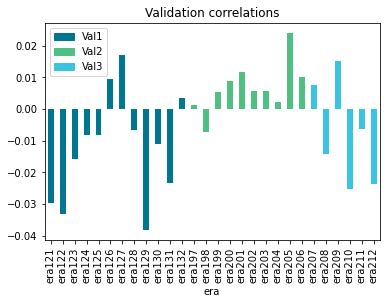

,0
mean,-0.004367
std,0.016012
sharpe,-0.272758
max_drawdown,-0.111516
max_feature_exp,0.423563
feature_exposure,0.145858
mmc_mean,-0.002824
corr_plus_mmc_sharpe,-0.252898
corr_plus_mmc_diff,0.019859


In [34]:
validation_data.reset_index(level=0, inplace=True)
numereval.diagnostics(validation_data, plot=True, 
                                example_preds_loc="/content/numerai_dataset_244/example_predictions.csv")

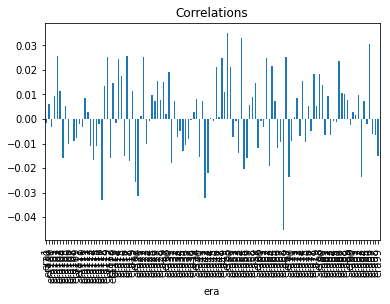

,0
mean,0.001030
std,0.015149
sharpe,0.067973
max_drawdown,-0.108731
max_feature_exp,0.045190
feature_exposure,0.001297


In [35]:
numereval.evaluate(training_data, plot=True, feature_exposure=True)

---

Future work: More customization and Signals metrics